In [1]:
!nvidia-smi

Tue Feb 27 13:25:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090 Ti     Off | 00000000:01:00.0 Off |                  Off |
| 30%   24C    P8              30W / 450W |      5MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# CLIP

### What is CLIP and what does it do?

OpenAI has introduced a novel model known as CLIP, standing for Contrastive Language-Image Pre-training. This advanced model is adept at learning the relationships between entire sentences and the images they describe. Distinct from traditional models that are trained on single labels such as 'car' or 'dog', CLIP benefits from training with full sentences. This method significantly improves its ability to discern and understand the complex interplay between text and images, enabling it to accurately retrieve images that correspond to the provided text.

The core advantage of employing full sentences in training lies in the model's enhanced capacity to identify and learn from the nuanced connections between text and imagery. By assimilating a broader range of information, CLIP can uncover patterns and relationships that surpass simple object identification.

Moreover, when CLIP undergoes training with a large dataset comprising images and their respective texts, it showcases an additional capability: acting as an image classifier. Notably, the CLIP model, trained through this comprehensive strategy, outclasses state-of-the-art (SOTA) models on the ImageNet benchmark, including those specifically fine-tuned for image classification tasks alone.

Exploring the research paper will provide deeper insights into the CLIP model, its innovative training approach, and its remarkable achievements on benchmark datasets. This model marks a significant leap forward in the integration of full sentences into machine learning frameworks, paving the way for improved understanding and performance in model development.

Let's first to install necessary libraries

In [1]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

/tmp/ipykernel_51293/491664227.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
dataset = "30k"
# Your code here!
!kaggle datasets download -d adityajn105/flickr30k

!unzip flickr30k.zip > /dev/null

flickr30k.zip: Skipping, found more recently modified local copy (use --force to force download)
replace Images/1000092795.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


## Some pre-preocessing

In [3]:
if dataset == "8k":
  df = pd.read_csv("captions.txt")
  df['id'] = [id_ for id_ in range(df.shape[0] // 5) for _ in range(5)]
  df.to_csv("captions.csv", index=False)
  df = pd.read_csv("captions.csv")
  image_path = "./Images"
  captions_path = "."
elif dataset == "30k":
  df = pd.read_csv("./Images/results.csv", delimiter="|")
  df.columns = ['image', 'caption_number', 'caption']
  df['caption'] = df['caption'].str.lstrip()
  df['caption_number'] = df['caption_number'].str.lstrip()
  df.loc[19999, 'caption_number'] = "4"
  df.loc[19999, 'caption'] = "A dog runs across the grass ."
  ids = [id_ for id_ in range(len(df) // 5) for _ in range(5)]
  df['id'] = ids
  df.to_csv("captions.csv", index=False)
  image_path = "./Images/"
  captions_path = "."

df.head()

,image,caption_number,caption,id
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...,0
1,1000092795.jpg,1,"Two young , White males are outside near many ...",0
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .,0
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .,0
4,1000092795.jpg,4,Two friends enjoy time spent together .,0


## Config

Defining the configuration used in CLIP

In [4]:
class CFG:
    debug = False
    image_path = image_path
    captions_path = captions_path
    batch_size = 64
    num_workers = 2
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_name = 'resnet50'
    image_embedding = 2048
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256
    dropout = 0.1

## Utils

In [5]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


## Dataset

To prepare the text for encoding, sentences (also referred to as captions) must first be tokenized using the DistilBERT tokenizer. This process converts the sentences into a series of token ids (input_ids) and generates the necessary attention masks, which are then inputted into the DistilBERT model. As such, the dataset must also handle the tokenization process to ensure the texts are appropriately formatted for the encoder.

The dataset's code is provided below. Following this, a detailed explanation will be given to clarify the key operations performed within the code, ensuring a comprehensive understanding of the data preparation process for image and text encoding.

In the `__init__` method, a tokenizer object, specifically from the HuggingFace tokenizer suite, is passed as a parameter. This tokenizer is initialized upon running the model. It is used to pad and truncate the captions to a pre-defined maximum length, ensuring uniformity in data input sizes.

Within the `__getitem__` method, the procedure begins by loading an encoded caption, which comes in the form of a dictionary containing the keys input_ids and attention_mask. The values of this dictionary are then converted into tensors. Following this, the corresponding image is loaded, processed, and optionally augmented before being converted into a tensor. This image tensor is then stored in the dictionary under the key "image".

Finally, the original text of the caption is added to the dictionary with the key "caption". This inclusion is primarily for visualization purposes, allowing for easier interpretation and analysis of the data during the training and evaluation phases.

In [6]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names
        """

        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=CFG.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        image = cv2.imread(f"{CFG.image_path}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]

        return item
        


    def __len__(self):
        return len(self.captions)



def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

## Image Encoder

The code for the image encoder is straightforward, utilizing the PyTorch Image Models (timm) library, which offers access to a wide range of image models from ResNets to EfficientNets, among others. In this instance, a ResNet50 model is selected as the image encoder. Alternatively, the torchvision library can also be used for employing ResNets without the need for installing an additional library.

The implemented code converts each image into a fixed-size vector, matching the size of the model's output channels. Specifically, for ResNet50, this results in a vector size of 2048. This transformation occurs after the application of the nn.AdaptiveAvgPool2d() layer, producing the final encoded output.

In [7]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

## Text Encoder

# Task2: Build the Text Encoder for CLIP using DistilBERT

Your task is to construct the text encoder component for the CLIP model, utilizing DistilBERT as the encoding framework. Similar to BERT, you will need to integrate two special tokens, CLS and SEP, at the beginning and end of your input text respectively. These tokens are crucial as they signify the start and end of a sentence.

Your primary objective is to capture the comprehensive meaning of a sentence, or caption, by using the final representation of the CLS token, as suggested by the DistilBERT and BERT literature. This approach mirrors the method applied to images, where they are transformed into fixed-size vectors.

In the context of DistilBERT (as well as BERT), the output hidden representation for each token, including the CLS token, is a vector of size 768. Therefore, your goal is to ensure that the entire caption is effectively encoded into the 768-sized representation of the CLS token, capturing the overall essence of the sentence.

In [8]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())

        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

## Projection Head

Now that both images and texts have been encoded into fixed-size vectors (2048 for images and 768 for texts), the next step involves projecting them into a common space with **similar dimensions**. This adjustment is crucial for enabling the comparison of the two different types of data. By aligning them within the same dimensional space, it becomes possible to distinguish and separate non-relevant image-text pairs while associating those that are compatible. The forthcoming code segment will transform the 2048-dimensional image vectors and 768-dimensional text vectors into a unified 256-dimensional space (referred to as "projection_dim"), facilitating effective comparison.

In this context, "embedding_dim" denotes the size of the input vector (2048 for images and 768 for texts), while "projection_dim" refers to the size of the output vector, which, in this scenario, is set to 256. For a deeper understanding of this process, consulting the CLIP paper is recommended.

In [9]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

## Combining CLIP

# Task3: Complete the CLIP Training Process

Your task is to complete the training process for the CLIP model by implementing the forward function within the CLIPModel class. This function is crucial for encoding images and texts, projecting them into a shared space, and computing the loss for model optimization.

Encode Images and Texts: Utilize the provided ImageEncoder and TextEncoder within the forward function to encode images and texts into fixed-size vectors. Note that these vectors will have different dimensionalities initially.

Project Encodings: Implement separate projection modules to transform the image and text encodings into a shared dimensional space, specifically into vectors of size 256. This step is necessary for comparing image and text representations effectively.

Compute the Loss: Calculate the loss based on the similarity between image and text vectors. This involves:

Calculating the dot product (using the @ operator in PyTorch) between image and text embeddings to obtain the logits matrix.
Transposing the necessary matrices to align dimensions for matrix multiplication.
Calculating the similarity scores within and between the groups of image and text embeddings.
Generating the targets matrix and calculating the cross-entropy loss between logits and targets.
Remember, the objective here is for the model to learn similar representations for corresponding images and texts, meaning that given either an image or its descriptive text, the model should produce matching 256-sized vectors for both.

You are encouraged to refer to the CLIP paper for a better understanding of the loss computation and its significance in the training process. Review the provided code snippets, focusing on the forward function, and complete it following the guidelines mentioned above. Ensure to check the shapes of the tensors at each step to confirm they align with the expected dimensions.

In [10]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    # Complete the forward operation
    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In an ideal situation, the text_embeddings and image_embeddings matrices would be identical, as they represent similar content. Now, let's ponder: if this were the case, how would the logits matrix appear? To understand this, consider the following simple example:

In [11]:
# A simple Example

batch_size = 4
dim = 256
embeddings = torch.randn(batch_size, dim)
out = embeddings @ embeddings.T
print(F.softmax(out, dim=-1))

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])


In the ideal scenario, the 'logits' would transform into a matrix where, upon applying the softmax function, the diagonal elements are 1.0s, resembling an identity matrix, to use more technical terminology. The primary role of the loss function is to align the model's predictions closely with the target values. Therefore, this desired outcome is reflected in our target matrix. This is precisely why the code calculates the 'images_similarity' and 'texts_similarity' matrices, aiming to guide the model towards producing such an alignment between image and text representations.

## Train

Here are several functions designed to assist in loading training and validation data loaders, initializing our model, and then conducting training and evaluation. This section primarily consists of a straightforward training loop and essential utility functions.

In [12]:
def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{CFG.captions_path}/captions.csv")
    max_id = dataframe["id"].max() + 1 if not CFG.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe


def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

This function is dedicated to training the model. It involves basic operations such as loading batches, passing them through the model, and updating the model parameters using the optimizer and learning rate scheduler.

In [13]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter


def main():
    train_df, valid_df = make_train_valid_dfs()
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")


    model = CLIPModel().to(CFG.device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )
    step = "epoch"

    best_loss = float('inf')
    for epoch in range(CFG.epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)

        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best.pt")
            print("Saved Best Model!")

        lr_scheduler.step(valid_loss.avg)

Running the next cell start training the model. Put the kernel on GPU mode. Every epoch should take about 8 minutes on GPU if you are using 8k version (even one epoch is enough!). It can take some seconds before training actually starts because we are going to encode all the captions once in the train and valid dataset, so please don't stop it! Every thing is working fine.

In [16]:
main()

Epoch: 1


  0%|          | 0/1987 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 2


  0%|          | 0/1987 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 3


  0%|          | 0/1987 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/1987 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

## Inference

Training of the model is now complete. The next step involves performing inference, where we provide the model with a piece of text and request it to retrieve the most relevant images from an unseen validation (or test) dataset.

Task4: Complete the Function for Retrieving Image Embeddings:

Your task is to implement the function `get_image_embeddings` which involves loading the trained model, processing images from the validation set, and returning the image embeddings along with the model itself. Here are the steps you need to follow:

1. Initialize the DistilBertTokenizer with the pre-trained configuration specified in CFG.text_tokenizer.

2. Construct the validation data loader by passing the validation DataFrame, the initialized tokenizer, and the mode set to "valid" to the `build_loaders` function.

3. Load the CLIPModel onto the specified device from CFG.device and load the trained model weights from the specified model_path.

4. Set the model to evaluation mode to disable dropout and batch normalization layers during inference.

5. Initialize an empty list `valid_image_embeddings` to store the image embeddings generated by the model.

6. Iterate over the validation data loader, process each batch to obtain image embeddings, and append these embeddings to the `valid_image_embeddings` list. Ensure that no gradient calculations are performed during this process by using `torch.no_grad()` context.

7. Concatenate all the image embeddings collected in the list to form a single tensor.

The output should be the trained model and a tensor containing the image embeddings for the validation set, with the tensor having the shape (valid_set_size, 256).

In [38]:
def get_image_embeddings(valid_df, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()

    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch["image"].to(CFG.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

In [39]:
_, valid_df = make_train_valid_dfs()
model, image_embeddings = get_image_embeddings(valid_df, "best.pt")

  0%|          | 0/497 [00:00<?, ?it/s]

# Task4: Implement the Function for Finding Matches

Your task is to complete a crucial part of the find_matches function, which showcases the primary capability of our model: retrieving the most relevant images from the validation set based on a text query.

We have completed the template for you. You need to generate the `text_embeddings` for similarity computation

In [95]:
def find_matches(model, image_embeddings, query, image_filenames, n=9):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)

    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T

    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]

    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{CFG.image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")

    plt.show()

## Test your function here.

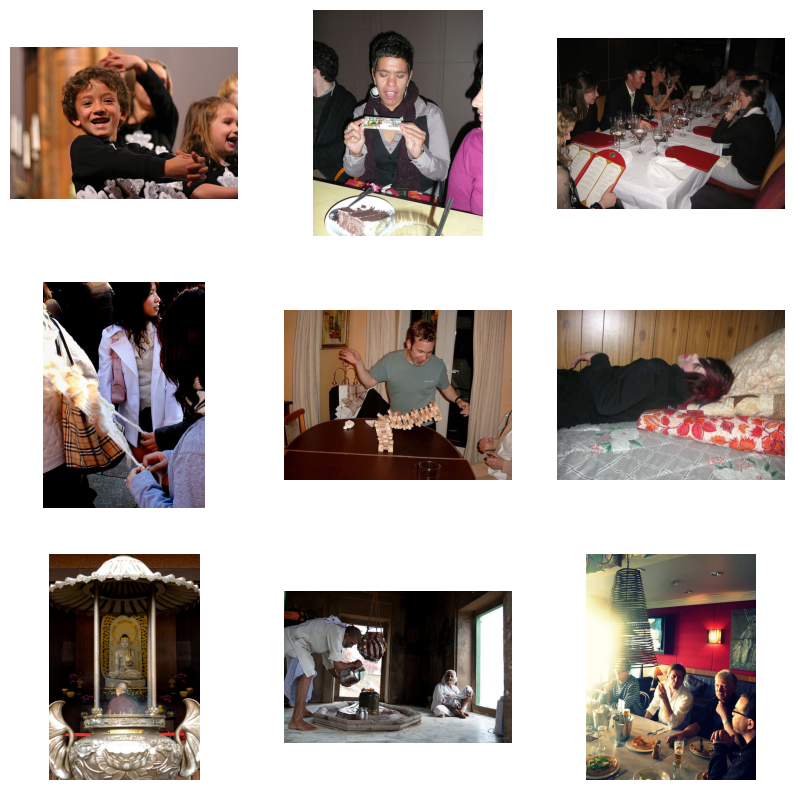

In [99]:
find_matches(model,
             image_embeddings,
             query="the cake is a lie",
             image_filenames=valid_df['image'].values,
             n=9)

## 

In [58]:
import pandas as pd
import os.path as path


p = "assignment/assignment/6644818/"
groups = {}
transforms = get_transforms(mode='eval')

model = CLIPModel().to(CFG.device)
model.load_state_dict(torch.load('best.pt', map_location=CFG.device))
model.eval()

tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)

for d in tqdm(os.listdir(p)):
    ds = []
    with open(path.join(p, d, "captions_candidates.txt"), 'r') as file: 
        ds = file.read().split('\n')

    images = []
    images_path = []
    
    for f in os.listdir(path.join(p, d, "images")):
        images_path.append(path.join(p, d, "images", f))
        
        image = cv2.imread(path.join(p, d, "images", f))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = transforms(image=image)['image']
        image = torch.tensor(image).permute(2, 0, 1).float()
        images.append(image)

    dataloader = torch.utils.data.DataLoader(
        images,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle = False,
    )
    
    valid_image_embeddings = []

    with torch.no_grad():
        for batch in dataloader:
            image_features = model.image_encoder(batch.to(CFG.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
            
    groups[d] = (ds, torch.cat(valid_image_embeddings), images_path)

  0%|          | 0/50 [00:00<?, ?it/s]

In [57]:

results = []

for g in tqdm(groups):
    captions, image_embeds, images_path = groups[g]
    
    n = 1
    
    for caption in captions:
        encoded_query = tokenizer([caption])
        
        batch = {
            key: torch.tensor(values).to(CFG.device)
            for key, values in encoded_query.items()
        }
    
        with torch.no_grad():
            text_features = model.text_encoder(
                input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
            )
            text_embeddings = model.text_projection(text_features)
    
        image_embeddings_n = F.normalize(image_embeds, p=2, dim=-1)
        text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
        dot_similarity = text_embeddings_n @ image_embeddings_n.T
    
        values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
        matches = [images_path[idx] for idx in indices[::5]]
    
        results.append((matches[0].replace('assignment/assignment/6644818/', ''), caption))

  0%|          | 0/50 [00:00<?, ?it/s]

In [55]:
pd.DataFrame.from_records(results).to_csv('res.csv', header=None, index=False)